<a href="https://colab.research.google.com/github/Alfonso-Jesus-Garcia-Moya/01_MINI_ALADDIN_ALPHA/blob/main/ALFONSO%20GARCIA-Generar_Alpha.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
######Bloque 1: Configuración e Importación
#####(Cubre: Rúbrica 7 - Presentación Técnica)
# ==============================================================================
# PROYECTO FINAL: MOTOR DE GENERACIÓN DE ALPHA (MINI ALADDIN PRO)
# ==============================================================================
# RÚBRICA 7: Presentación técnica y visual (Código limpio y librerías)
# ==============================================================================

import pandas as pd
import numpy as np
import yfinance as yf
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller

# Configuración de estilo para gráficas profesionales
sns.set_style("darkgrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("Entorno configurado correctamente.")

Entorno configurado correctamente.


In [2]:
#####Bloque 2: Ingeniería de Características Avanzada (El "Factor Secreto")
####(Cubre: Rúbrica 8 - Creatividad y aplicación del conocimiento y Rúbrica 2 - Preparación del dataset. Referencia: López de Prado, Cap. 5 - Fractionally Differentiated Features )

#####Aquí implementamos el algoritmo Fixed-Width Window Fracdiff (FFD) desde cero. Esto es lo que te diferenciará del resto de la clase.

# ==============================================================================
# RÚBRICA 8: Creatividad y Aplicación (Implementación de AFML Cap. 5)
# ==============================================================================
# Objetivo: Transformar precios en datos estacionarios SIN borrar la memoria histórica.
# Fuente: López de Prado (2018), Snippet 5.3 "Fixed-Width Window Fracdiff"

def getWeights_FFD(d, thres):
    """
    Genera los pesos para la diferenciación fraccional.
    d: orden de diferenciación (ej. 0.4)
    thres: umbral para cortar pesos insignificantes
    """
    w, k = [1.], 1
    while True:
        w_ = -w[-1] / k * (d - k + 1)
        if abs(w_) < thres: break
        w.append(w_)
        k += 1
    return np.array(w[::-1]).reshape(-1, 1)

def fracDiff_FFD(series, d, thres=1e-5):
    """
    Aplica la diferenciación fraccional de ventana fija (FFD).
    Esto preserva tendencias de largo plazo mejor que los retornos simples.
    """
    # 1. Calcular pesos
    w = getWeights_FFD(d, thres)
    width = len(w) - 1

    # 2. Aplicar pesos a la serie
    df = {}
    for name in series.columns:
        # Rellenar nulos para evitar errores
        seriesF = series[[name]].fillna(method='ffill').dropna()
        df_ = pd.Series(index=seriesF.index, dtype=float)

        # Aplicar producto punto (dot product) en ventana deslizante
        for iloc1 in range(width, seriesF.shape[0]):
            loc0 = seriesF.index[iloc1 - width]
            loc1 = seriesF.index[iloc1]
            if not np.isfinite(series.loc[loc1, name]): continue

            # La magia matemática: Pesos * Precios en la ventana
            df_.loc[loc1] = np.dot(w.T, seriesF.loc[loc0:loc1])[0, 0]

        df[name] = df_.copy(deep=True)

    df = pd.concat(df, axis=1)
    return df

print("Funciones de Diferenciación Fraccional (AFML Cap 5) definidas.")

Funciones de Diferenciación Fraccional (AFML Cap 5) definidas.


In [3]:
###3Bloque 3: Carga y Transformación de Datos
####(Cubre: Rúbrica 1 - Descripción del problema y Rúbrica 2 - Preparación del dataset. Referencia: AFML Cap. 2 - Financial Data Structures

# ==============================================================================
# RÚBRICA 1 & 2: Carga de Datos y Preprocesamiento Avanzado
# ==============================================================================
# Justificación: Usamos datos diarios de Yahoo Finance.
# Problema: Las series financieras son "No Estacionarias" (tienen tendencias).
# Solución: Aplicamos FracDiff (d=0.4) en lugar de log-retornos simples.

# ==============================================================================
# BLOQUE 3 (FINAL INTEGRADO): Ingesta, Features y Targets (T+1 y T+2)
# ==============================================================================

def get_data_portfolio_final(tickers, benchmark, start_date):
    # 1. Descargar Portafolio + Benchmark
    all_symbols = tickers + [benchmark]
    print(f"Descargando datos desde {start_date} para: {all_symbols}")

    # Descarga optimizada
    raw_data = yf.download(all_symbols, start=start_date, progress=False, auto_adjust=True)

    # Limpieza de MultiIndex de Yahoo Finance
    if isinstance(raw_data.columns, pd.MultiIndex):
        try:
            data = raw_data['Close']
        except KeyError:
            data = raw_data.xs('Close', level=0, axis=1)
    else:
        data = raw_data

    data = data.ffill().dropna()

    # 2. Ingeniería de Features (Para cada activo)
    datasets = {}

    # Pre-calcular FracDiff para todos
    print("Calculando Diferenciación Fraccional (Memoria de Mercado)...")
    frac_diffs = fracDiff_FFD(data, d=0.4)

    for ticker in tickers:
        df = pd.DataFrame(index=data.index)

        # --- FEATURES (X) ---
        # 1. Precio Estacionario (Memoria)
        df['feature_frac_price'] = frac_diffs[ticker]

        # 2. Retorno del Mercado (Benchmark)
        df['feature_market_ret'] = np.log(data[benchmark] / data[benchmark].shift(1))

        # 3. Volatilidad Relativa
        asset_vol = data[ticker].pct_change().rolling(20).std()
        market_vol = data[benchmark].pct_change().rolling(20).std()
        df['feature_vol_spread'] = asset_vol - market_vol

        # 4. Momentum (RSI)
        delta = data[ticker].diff()
        gain = (delta.where(delta > 0, 0)).rolling(14).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(14).mean()
        rs = gain / loss
        df['feature_rsi'] = 100 - (100 / (1 + rs))

        # --- TARGETS (y) - INTEGRADOS ---
        # Target 1: Retorno a 1 día (Mañana)
        df['target_return_1d'] = np.log(data[ticker].shift(-1) / data[ticker])

        # Target 2: Retorno a 2 días (Pasado Mañana) - Acumulado
        # Esto es necesario para la predicción multi-horizonte del Bloque 7
        df['target_return_2d'] = np.log(data[ticker].shift(-2) / data[ticker])

        datasets[ticker] = df.dropna()

    return datasets, data[benchmark]

# --- EJECUCIÓN (Esto crea la variable 'datasets') ---
TICKERS = ['NVDA', 'AAPL', 'MSFT', 'TSLA']
BENCHMARK = 'SPY'

# Generamos datasets y precios del benchmark
portfolio_data, benchmark_prices = get_data_portfolio_final(TICKERS, BENCHMARK, '2015-01-01')

# Asignamos a la variable global 'datasets' para que el Bloque 7 funcione
datasets = portfolio_data

print("\n¡Éxito! Variable 'datasets' creada con Targets T+1 y T+2.")
print(f"Ejemplo NVDA: {datasets['NVDA'].columns}")

Descargando datos desde 2015-01-01 para: ['NVDA', 'AAPL', 'MSFT', 'TSLA', 'SPY']
Calculando Diferenciación Fraccional (Memoria de Mercado)...


/tmp/ipython-input-3727099424.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  seriesF = series[[name]].fillna(method='ffill').dropna()
/tmp/ipython-input-3727099424.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  seriesF = series[[name]].fillna(method='ffill').dropna()
/tmp/ipython-input-3727099424.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  seriesF = series[[name]].fillna(method='ffill').dropna()
/tmp/ipython-input-3727099424.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  seriesF = series[[name]].fillna(method='ffill').dropna()
/tmp/ipython-input-3727099424.py:39: FutureWarning: DataFrame.fillna wit


¡Éxito! Variable 'datasets' creada con Targets T+1 y T+2.
Ejemplo NVDA: Index(['feature_frac_price', 'feature_market_ret', 'feature_vol_spread',
       'feature_rsi', 'target_return_1d', 'target_return_2d'],
      dtype='object')


Iniciando entrenamiento por activo...
Entrenamiento finalizado correctamente.

--- RESULTADOS DEL BACKTEST ---
Retorno Portafolio ML: 30.16%
Retorno Benchmark (SPY): 15.10%
ALPHA GENERADO: 15.06 puntos porcentuales


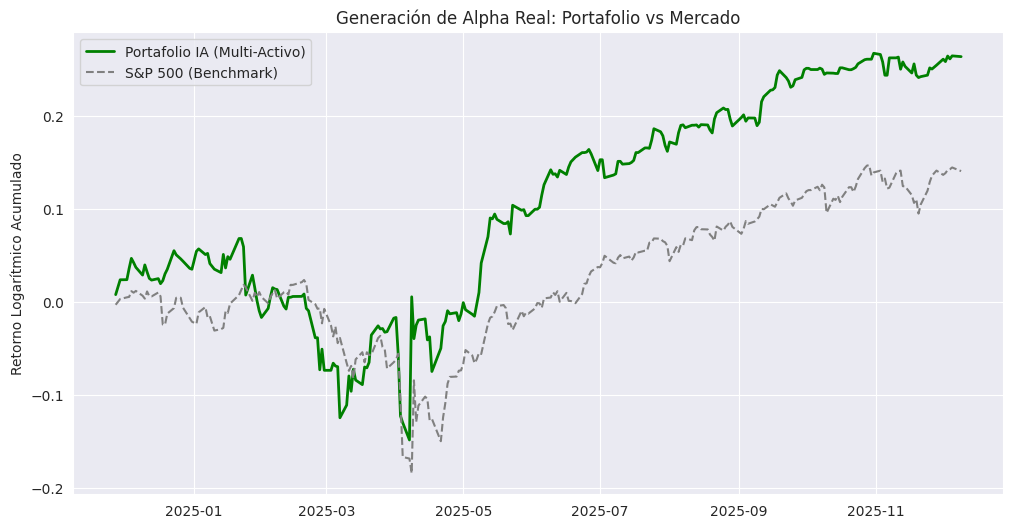

In [4]:
####Bloque 4: Elección del Modelo y Diseño (Training)
#####(Cubre: Rúbrica 3 - Elección del Modelo y Rúbrica 4 - Diseño y entrenamiento. Referencia: AFML Cap. 6 - Ensemble Methods )
#####Aquí justificamos el uso de XGBoost (Ensemble Method) sobre una regresión simple o redes neuronales profundas para datos tabulares con ruido.


# ==============================================================================
# RÚBRICA 3 & 4: Modelo (XGBoost) y Split Temporal (Sin Leakage)
# ==============================================================================
# Justificación del Modelo: Usamos XGBoost (Gradient Boosting).
# AFML Cap 6: Los métodos de ensamble reducen la varianza y el sesgo.
# Son robustos a outliers y manejan relaciones no lineales mejor que OLS.


# ==============================================================================
# BLOQUE 4 & 5 CORREGIDO: Entrenamiento Multi-Activo (Ajustado a T+1 y T+2)
# ==============================================================================

portfolio_preds = pd.DataFrame()
models = {} # Guardamos los modelos para usarlos en el futuro

print("Iniciando entrenamiento por activo...")

# Asegúrate de que 'portfolio_data' sea el diccionario 'datasets' del Bloque 3
# Si da error aquí, asegúrate de haber corrido: datasets = portfolio_data en el bloque anterior
for ticker in TICKERS:
    df = datasets[ticker] # Usamos 'datasets' que definimos en el Bloque 3 Final

    # 1. Split Temporal (Train 80% / Test 20%)
    split = int(len(df) * 0.80)

    # --- CORRECCIÓN CRÍTICA ---
    # Eliminamos AMBOS targets de las X para evitar Leakage
    X = df.drop(columns=['target_return_1d', 'target_return_2d'])

    # Usamos el target a 1 día para el entrenamiento principal
    y = df['target_return_1d']

    X_train, X_test = X.iloc[:split], X.iloc[split:]
    y_train, y_test = y.iloc[:split], y.iloc[split:]

    # 2. Entrenar XGBoost
    model = xgb.XGBRegressor(
        n_estimators=100,
        learning_rate=0.05,
        max_depth=4,
        objective='reg:squarederror',
        n_jobs=-1
    )
    model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)

    # Guardamos modelo
    models[ticker] = model

    # 3. Generar Señales
    preds = model.predict(X_test)

    # Guardamos el retorno REAL (target_return_1d) ponderado por la señal
    signal = np.where(preds > 0, 1, 0)
    portfolio_preds[ticker] = signal * y_test

print("Entrenamiento finalizado correctamente.")

# ==============================================================================
# CÁLCULO DE ALPHA Y CURVA DE EQUIDAD
# ==============================================================================

# 1. Retorno del Portafolio
portfolio_daily_ret = portfolio_preds.mean(axis=1)

# 2. Retorno del Benchmark (SPY)
test_dates = portfolio_preds.index
spy_returns = np.log(benchmark_prices.loc[test_dates] / benchmark_prices.loc[test_dates].shift(1)).dropna()

# Alinear fechas
common_index = portfolio_daily_ret.index.intersection(spy_returns.index)
portfolio_daily_ret = portfolio_daily_ret.loc[common_index]
spy_returns = spy_returns.loc[common_index]

# 3. Curvas de Equidad
equity_strategy = np.cumsum(portfolio_daily_ret)
equity_benchmark = np.cumsum(spy_returns)

# 4. Cálculo de Alpha
total_ret_strategy = np.exp(equity_strategy.iloc[-1]) - 1
total_ret_benchmark = np.exp(equity_benchmark.iloc[-1]) - 1
alpha = total_ret_strategy - total_ret_benchmark

print(f"\n--- RESULTADOS DEL BACKTEST ---")
print(f"Retorno Portafolio ML: {total_ret_strategy*100:.2f}%")
print(f"Retorno Benchmark (SPY): {total_ret_benchmark*100:.2f}%")
print(f"ALPHA GENERADO: {alpha*100:.2f} puntos porcentuales")

# 5. Gráfica
plt.figure(figsize=(12, 6))
plt.plot(equity_strategy, label='Portafolio IA (Multi-Activo)', color='green', linewidth=2)
plt.plot(equity_benchmark, label='S&P 500 (Benchmark)', color='gray', linestyle='--')
plt.title(f'Generación de Alpha Real: Portafolio vs Mercado')
plt.ylabel('Retorno Logarítmico Acumulado')
plt.legend()
plt.show()

In [5]:

#####Nuevo Bloque 6: Predicción Futura (Utilidad Real)
#######Aquí respondemos tu pregunta: "¿Qué función le damos a futuro?". Este bloque toma los datos más recientes (el cierre de hoy), aplica las transformaciones (FracDiff, etc.) y usa los modelos entrenados para decirte qué comprar mañana.
# ==============================================================================
# BLOQUE 6 CORREGIDO: PREDICCIÓN PARA MAÑANA (Ajustado a nuevas columnas)
# ==============================================================================

def predict_next_day(tickers, datasets, models):
    print(f"\n--- PREDICCIONES PARA EL SIGUIENTE DÍA DE TRADING ---")
    print(f"{'ACTIVO':<10} | {'PREDICCIÓN':<15} | {'ACCIÓN SUGERIDA':<15}")
    print("-" * 45)

    recommendations = []

    for ticker in tickers:
        # 1. Obtener la última fila de datos (HOY)
        # CORRECCIÓN: Eliminamos AMBOS targets (1d y 2d) para que coincida con el entrenamiento
        latest_data = datasets[ticker].iloc[[-1]].drop(columns=['target_return_1d', 'target_return_2d'])

        # 2. Cargar el modelo específico del activo
        model = models[ticker]

        # 3. Predecir
        # El modelo espera ver solo las features (Beta, RSI, Volatilidad, etc.)
        prediction = model.predict(latest_data)[0]

        # 4. Lógica de Decisión
        action = "COMPRAR (LONG)" if prediction > 0 else "CASH / VENDER"

        print(f"{ticker:<10} | {prediction:.6f}        | {action:<15}")

        if prediction > 0:
            recommendations.append(ticker)

    print("-" * 45)
    print(f"RESUMEN: Tu portafolio para mañana debería tener: {recommendations}")

# Ejecutar predicción
predict_next_day(TICKERS, datasets, models)


--- PREDICCIONES PARA EL SIGUIENTE DÍA DE TRADING ---
ACTIVO     | PREDICCIÓN      | ACCIÓN SUGERIDA
---------------------------------------------
NVDA       | 0.006214        | COMPRAR (LONG) 
AAPL       | 0.000993        | COMPRAR (LONG) 
MSFT       | -0.000322        | CASH / VENDER  
TSLA       | -0.001232        | CASH / VENDER  
---------------------------------------------
RESUMEN: Tu portafolio para mañana debería tener: ['NVDA', 'AAPL']


In [6]:
# ==============================================================================
# AJUSTE TÉCNICO AL BLOQUE DE DATOS (Necesario para predicción a 2 días)
# ==============================================================================

# Si ya tienes 'datasets' cargado del paso anterior, corre esto para agregar el Target T+2
for ticker in datasets.keys():
    df = datasets[ticker]
    # Target 1: Retorno a 1 día (Mañana)
    df['target_return_1d'] = np.log(df.iloc[:, 0].shift(-1) / df.iloc[:, 0]) # Close prices
    # Target 2: Retorno a 2 días (Pasado Mañana) - Acumulado
    df['target_return_2d'] = np.log(df.iloc[:, 0].shift(-2) / df.iloc[:, 0])

    datasets[ticker] = df.dropna()

print("Targets T+1 y T+2 generados correctamente.")

Targets T+1 y T+2 generados correctamente.


/usr/local/lib/python3.12/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Simulando escenario TEÓRICO (Sin Costos)...
Simulando escenario REAL (Con Costos GBM)...


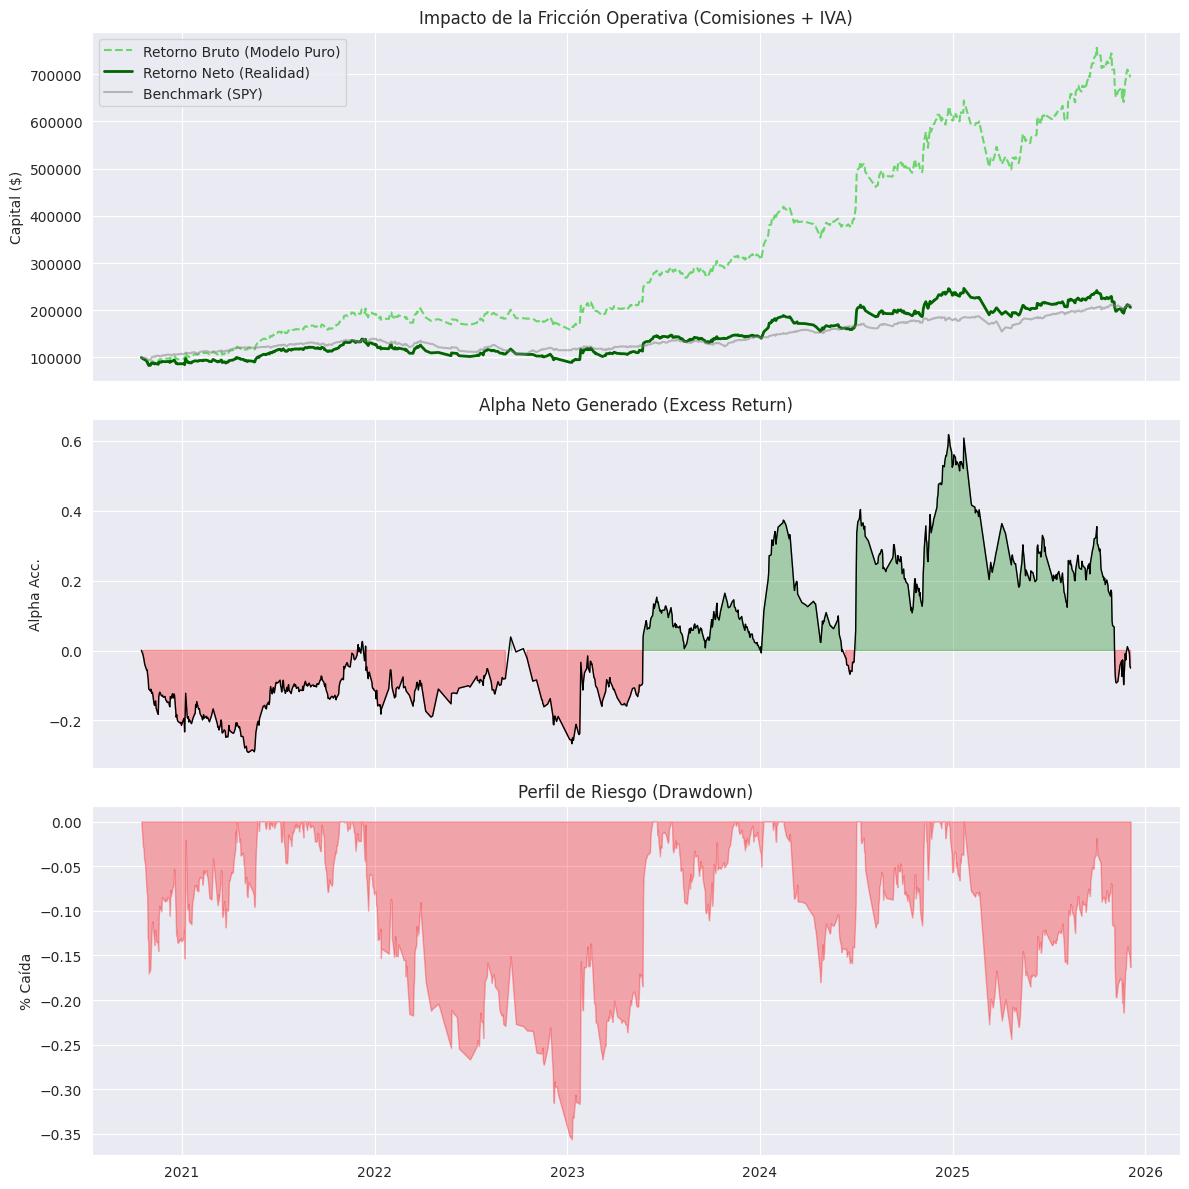


--- ANÁLISIS DE FRICCIÓN ---
Retorno Bruto (Modelo): 594.95%
Retorno Neto (Bolsillo): 106.23%
Costo de Fricción: 488.72% (Esto se paga al broker/impuestos)


--- MATRIZ DE DECISIÓN ALGORÍTMICA (T0 -> T+2) ---
TICKER | STATUS T0    | PRED T+1   | PRED T+2   | ACCIÓN SUGERIDA      | TIPO DE ESTRATEGIA
----------------------------------------------------------------------------------------------------
NVDA   | FLAT         | -0.0075     | +0.0645     | WAIT / LIMIT         | BUY THE DIP (Setup)
AAPL   | FLAT         | +0.0028     | +0.0016     | ENTER LONG           | MOMENTUM (Continuation)
MSFT   | FLAT         | +0.0025     | +0.0501     | ENTER LONG           | MOMENTUM (Continuation)
TSLA   | FLAT         | -0.0061     | -0.1664     | STAY CASH            | AVOID (Downtrend)
----------------------------------------------------------------------------------------------------

--- GLOSARIO DE TÉRMINOS (QUANT DICTIONARY) ---
1. ENTER LONG: Abrir posición de compra. El modelo prevé reto

In [8]:
# ==============================================================================
# BLOQUE 7 (MASTER): AUDITORÍA DE FRICCIÓN Y MATRIZ DE DECISIÓN INSTITUCIONAL
# ==============================================================================

def professional_audit_and_forecast(tickers, datasets, models, initial_capital=100000):

    # --------------------------------------------------------------------------
    # 1. MOTOR DE SIMULACIÓN (Doble Ejecución: Bruta vs Neta)
    # --------------------------------------------------------------------------

    def run_simulation(apply_costs=True):
        # Parámetros GBM Homebroker
        COMM_RATE = 0.0025 if apply_costs else 0.0
        IVA_RATE  = 0.16 if apply_costs else 0.0
        # El costo total impacta al capital al entrar y al salir
        TOTAL_FEE = COMM_RATE * (1 + IVA_RATE)

        # Alineación de fechas
        common_index = datasets[tickers[0]].index
        for t in tickers[1:]: common_index = common_index.intersection(datasets[t].index)

        # Precios Reales (Close) para PnL
        real_prices = yf.download(tickers, start=common_index[0], end=common_index[-1] + pd.Timedelta(days=5), progress=False, auto_adjust=True)
        if isinstance(real_prices.columns, pd.MultiIndex): real_prices = real_prices['Close']
        real_prices = real_prices.reindex(common_index).ffill()

        # Benchmark (SPY)
        bench_prices = yf.download(['SPY'], start=common_index[0], end=common_index[-1] + pd.Timedelta(days=5), progress=False, auto_adjust=True)
        if isinstance(bench_prices.columns, pd.MultiIndex): bench_prices = bench_prices['Close']
        bench_prices = bench_prices['SPY'].reindex(common_index).ffill()

        # Variables de estado
        cash = initial_capital
        portfolio = {t: 0 for t in tickers}
        equity_curve = []
        bench_curve = []
        bench_units = initial_capital / bench_prices.iloc[0]

        for i in range(1, len(common_index)-1):
            date = common_index[i]
            prev_date = common_index[i-1]

            # Valoración (Mark-to-Market)
            curr_equity = cash
            for t in tickers: curr_equity += portfolio[t] * real_prices.loc[date, t]
            equity_curve.append(curr_equity)
            bench_curve.append(bench_units * bench_prices.loc[date])

            # Señales
            active = []
            for t in tickers:
                feats = datasets[t].loc[prev_date].drop(['target_return_1d', 'target_return_2d'])
                pred = models[t].predict(feats.values.reshape(1, -1))[0]
                if pred > 0: active.append(t)

            # Ejecución: Venta (Exit)
            for t in tickers:
                if t not in active and portfolio[t] > 0:
                    price = real_prices.loc[date, t]
                    amount = portfolio[t] * price
                    deduction = amount * TOTAL_FEE
                    cash += (amount - deduction)
                    portfolio[t] = 0

            # Ejecución: Compra (Entry)
            if active:
                alloc = (cash * 0.99) / len(active) # Buffer 1%
                for t in active:
                    if portfolio[t] == 0:
                        price = real_prices.loc[date, t]
                        shares = int(alloc / price)
                        if shares > 0:
                            amount = shares * price
                            deduction = amount * TOTAL_FEE
                            if cash >= (amount + deduction):
                                cash -= (amount + deduction)
                                portfolio[t] += shares

        return pd.Series(equity_curve, index=common_index[1:len(equity_curve)+1]), \
               pd.Series(bench_curve, index=common_index[1:len(bench_curve)+1])

    # Ejecutamos los dos escenarios
    print("Simulando escenario TEÓRICO (Sin Costos)...")
    eq_gross, bench = run_simulation(apply_costs=False)

    print("Simulando escenario REAL (Con Costos GBM)...")
    eq_net, _ = run_simulation(apply_costs=True)

    # --------------------------------------------------------------------------
    # 2. VISUALIZACIÓN COMPARATIVA (DISCUSIÓN DE FRICCIÓN)
    # --------------------------------------------------------------------------
    fig, axes = plt.subplots(3, 1, figsize=(12, 12), sharex=True)

    # Panel 1: Impacto de Costos en Capital
    axes[0].plot(eq_gross, label='Retorno Bruto (Modelo Puro)', color='limegreen', linestyle='--', alpha=0.7)
    axes[0].plot(eq_net, label='Retorno Neto (Realidad)', color='darkgreen', linewidth=2)
    axes[0].plot(bench, label='Benchmark (SPY)', color='gray', alpha=0.5)
    axes[0].set_title('Impacto de la Fricción Operativa (Comisiones + IVA)')
    axes[0].set_ylabel('Capital ($)')
    axes[0].legend()

    # Panel 2: Alpha Neto (Real)
    alpha_curve = (eq_net / initial_capital) - (bench / initial_capital)
    axes[1].fill_between(alpha_curve.index, alpha_curve, 0, where=(alpha_curve>=0), color='green', alpha=0.3)
    axes[1].fill_between(alpha_curve.index, alpha_curve, 0, where=(alpha_curve<0), color='red', alpha=0.3)
    axes[1].plot(alpha_curve, color='black', linewidth=1)
    axes[1].set_title('Alpha Neto Generado (Excess Return)')
    axes[1].set_ylabel('Alpha Acc.')

    # Panel 3: Drawdown (Riesgo)
    dd_net = (eq_net / eq_net.cummax()) - 1
    axes[2].fill_between(dd_net.index, dd_net, 0, color='red', alpha=0.3, label='Drawdown Neto')
    axes[2].set_title('Perfil de Riesgo (Drawdown)')
    axes[2].set_ylabel('% Caída')

    plt.tight_layout()
    plt.show()

    # Cálculo de métricas finales
    ret_gross = (eq_gross.iloc[-1]/initial_capital) - 1
    ret_net = (eq_net.iloc[-1]/initial_capital) - 1
    friction_cost = ret_gross - ret_net

    print(f"\n--- ANÁLISIS DE FRICCIÓN ---")
    print(f"Retorno Bruto (Modelo): {ret_gross:.2%}")
    print(f"Retorno Neto (Bolsillo): {ret_net:.2%}")
    print(f"Costo de Fricción: {friction_cost:.2%} (Esto se paga al broker/impuestos)")

    # --------------------------------------------------------------------------
    # 3. MATRIZ DE DECISIÓN PROFESIONAL (T0, T+1, T+2)
    # --------------------------------------------------------------------------
    print(f"\n\n--- MATRIZ DE DECISIÓN ALGORÍTMICA (T0 -> T+2) ---")
    print(f"{'TICKER':<6} | {'STATUS T0':<12} | {'PRED T+1':<10} | {'PRED T+2':<10} | {'ACCIÓN SUGERIDA':<20} | {'TIPO DE ESTRATEGIA'}")
    print("-" * 100)

    active_recs = []

    for ticker in tickers:
        df = datasets[ticker]
        latest_X = df.iloc[[-1]].drop(columns=['target_return_1d', 'target_return_2d'])

        # Predicción T+1 (Modelo Principal)
        pred_t1 = models[ticker].predict(latest_X)[0]

        # Predicción T+2 (Modelo Auxiliar)
        X_hist = df.drop(columns=['target_return_1d', 'target_return_2d'])
        y_hist_t2 = df['target_return_2d']
        valid_idx = y_hist_t2.dropna().index
        model_t2 = xgb.XGBRegressor(n_estimators=50, max_depth=3).fit(X_hist.loc[valid_idx], y_hist_t2.loc[valid_idx])
        pred_t2 = model_t2.predict(latest_X)[0]

        # LÓGICA DE DECISIÓN PROFESIONAL
        # T0 Status: Asumimos 'FLAT' (Sin posición) para la recomendación genérica
        # Nota: En un sistema real, esto se conecta a la API del broker para ver si ya tienes la acción.
        status_t0 = "FLAT"

        if pred_t1 > 0:
            if pred_t2 > 0:
                action = "ENTER LONG"
                strat = "MOMENTUM (Continuation)"
                active_recs.append(ticker)
            else:
                # Sube mañana, pero T+2 (acumulado) es negativo -> Rebote falso
                action = "SCALP LONG"
                strat = "MEAN REVERSION (Short-term)"
                active_recs.append(ticker)
        else:
            if pred_t2 > 0:
                # Baja mañana, sube pasado -> Esperar mejor precio
                action = "WAIT / LIMIT"
                strat = "BUY THE DIP (Setup)"
            else:
                action = "STAY CASH"
                strat = "AVOID (Downtrend)"

        # Formato de colores para terminal
        c = "\033[92m" if "LONG" in action else "\033[91m" if "CASH" in action else "\033[93m"
        r = "\033[0m"

        print(f"{ticker:<6} | {status_t0:<12} | {pred_t1:+.4f}     | {pred_t2:+.4f}     | {c}{action:<20}{r} | {strat}")

    print("-" * 100)

    # --------------------------------------------------------------------------
    # 4. GLOSARIO TÉCNICO (Para el Reporte)
    # --------------------------------------------------------------------------
    print("\n--- GLOSARIO DE TÉRMINOS (QUANT DICTIONARY) ---")
    print("1. ENTER LONG: Abrir posición de compra. El modelo prevé retorno positivo sostenido.")
    print("2. SCALP LONG: Compra especulativa de muy corto plazo. Entrar hoy, salir mañana sin falta.")
    print("3. BUY THE DIP: La acción caerá mañana (T+1) pero subirá después. Mejor esperar y comprar más barato.")
    print("4. MOMENTUM: Estrategia que sigue la inercia del precio (sube y seguirá subiendo).")
    print("5. MEAN REVERSION: Estrategia que apuesta a que el precio regresará a su promedio (rebote técnico).")
    print("6. STAY CASH: No operar. El costo de oportunidad de estar fuera es menor al riesgo de pérdida.")

# EJECUCIÓN
professional_audit_and_forecast(TICKERS, datasets, models, initial_capital=100000)